In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing, pipeline, metrics, model_selection

pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100
sns.set_style("white")
%matplotlib inline

# Load data

Typically for every Kaggle competition there will be at least two datasets: train and test. You are supposed to train a model or models on the train dataset and make predictions on the test dataset, and make submissions based on your predictions. Kaggle will evaluate your submissions by comparing your predictions against the actual labels of the test dataset which is unseen to participants. 

Most of the time we will simply load the datasets using Pandas, a Python packages for data analysis and manipulation, in a format of a dataframe which you can imagine it as a table or a CSV file. 

In [2]:
train_df = pd.read_json('/kaggle/input/two-sigma-connect-rental-listing-inquiries/train.json.zip', convert_dates=['created'])
test_df = pd.read_json('/kaggle/input/two-sigma-connect-rental-listing-inquiries/test.json.zip', convert_dates=['created'])

# Set listing_id as the index
train_df.set_index('listing_id', inplace=True)
test_df.set_index('listing_id', inplace=True)

# Summary

There are a few things we are interested in order to have a high level understanding of the data:

* What is size of the data? 
* Number of samples?
* How many features(columns)?
* Data types?

Pandas' info() function is an useful tool that gives a quick summary about the data:

In [3]:
# Basic information
print("Information of training data:")
print(train_df.info())

print('\n')

print("Information of test data:")
print(test_df.info())

Information of training data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 7170325 to 6901023
Data columns (total 14 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null datetime64[ns]
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
latitude           49352 non-null float64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
interest_level     49352 non-null object
dtypes: datetime64[ns](1), float64(3), int64(2), object(8)
memory usage: 5.6+ MB
None


Information of test data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 7142618 to 6889319
Data columns (total 13 columns):
bathrooms          74659 non-null float

You can also check the "shape" attribute of a Pandas dataframes:

In [4]:
print("There are {} rows and {} columns in the training data".format(train_df.shape[0], train_df.shape[1]))
print("There are {} rows and {} columns in the test data".format(test_df.shape[0], test_df.shape[1]))

There are 49352 rows and 14 columns in the training data
There are 74659 rows and 13 columns in the test data


It is recommended to **group features by data types**. 

In [5]:
# numeric variables
num_cols = list(train_df.select_dtypes('number').columns)

# categorical variables
cat_cols = list(train_df.select_dtypes('object').columns)
cat_cols.remove('interest_level')

# datetime variables
dt_cols = list(train_df.select_dtypes('datetime').columns)

# index column
id_col = 'listing_id'

# target column
target_col = 'interest_level'

print("Numeric variables: ", num_cols)
print("Categorical variables: ", cat_cols)
print("Datetime variables: ", dt_cols)
print("Index variable: ", id_col)
print("Target variable: ", target_col)

Numeric variables:  ['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price']
Categorical variables:  ['building_id', 'description', 'display_address', 'features', 'manager_id', 'photos', 'street_address']
Datetime variables:  ['created']
Index variable:  listing_id
Target variable:  interest_level


We can use head() function to have a sneak peek of the data:

In [6]:
train_df.head()

bathrooms  bedrooms                       building_id  \
listing_id                                                          
7170325           1.0         1  8579a0b0d54db803821a35a4a615e97a   
7092344           1.0         2  b8e75fc949a6cd8225b455648a951712   
7158677           1.0         2  cd759a988b8f23924b5a2058d5ab2b49   
7211212           1.5         3  53a5b119ba8f7b61d4e010512e0dfc85   
7225292           1.0         0  bfb9405149bfff42a92980b594c28234   

                       created  \
listing_id                       
7170325    2016-06-16 05:55:27   
7092344    2016-06-01 05:44:33   
7158677    2016-06-14 15:19:59   
7211212    2016-06-24 07:54:24   
7225292    2016-06-28 03:50:23   

                                                                                                    description  \
listing_id                                                                                                        
7170325     Spacious 1 Bedroom 1 Bathroom in Williamsburg!Apartment Features:- Renovated Eat in Kitchen With...   
7092344     BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind yourself and your home in the center of it all. Steps...   
7158677     **FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**Looking for the perfect apartment in Midtown East -...   
7211212     A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Her...   
7225292     Over-sized Studio w abundant closets. Available Immediately.<br /><br />Rent Stabilized. Shares:...   

                display_address  \
listing_id                        
7170325     145 Borinquen Place   
7092344               East 44th   
7158677        East 56th Street   
7211212     Metropolitan Avenue   
7225292        East 34th Street   

                                                                                                       features  \
listing_id                                                                                                        
7170325     [Dining Room, Pre-War, Laundry in Building, Dishwasher, Hardwood Floors, Dogs Allowed, Cats Allo...   
7092344                           [Doorman, Elevator, Laundry in Building, Dishwasher, Hardwood Floors, No Fee]   
7158677                  [Doorman, Elevator, Laundry in Building, Laundry in Unit, Dishwasher, Hardwood Floors]   
7211212                                                                                                      []   
7225292                                                [Doorman, Elevator, Fitness Center, Laundry in Building]   

            latitude  longitude                        manager_id  \
listing_id                                                          
7170325      40.7108   -73.9539  a10db4590843d78c784171a107bdacb4   
7092344      40.7513   -73.9722  955db33477af4f40004820b4aed804a0   
7158677      40.7575   -73.9625  c8b10a317b766204f08e613cef4ce7a0   
7211212      40.7145   -73.9425  5ba989232d0489da1b5f2c45f6688adc   
7225292      40.7439   -73.9743  2c3b41f588fbb5234d8a1e885a436cfa   

                                                                                                         photos  \
listing_id                                                                                                        
7170325     [https://photos.renthop.com/2/7170325_3bb5ac84a5a10227b17b273e79bd77b4.jpg, https://photos.renth...   
7092344     [https://photos.renthop.com/2/7092344_7663c19af02c46104bc4c569f7162ae0.jpg, https://photos.renth...   
7158677     [https://photos.renthop.com/2/7158677_c897a134b77dc1c772a663874da69315.jpg, https://photos.renth...   
7211212     [https://photos.renthop.com/2/7211212_1ed4542ec81621d70d1061aa833e669c.jpg, https://photos.renth...   
7225292     [https://photos.renthop.com/2/7225292_901f19847d2db115feda6e7a6b6ba08b.jpg, https://photos.renth...   

            price           street_address interest_level  
listing_id                                                 
7170325      2400    

One of the most common data issues is having missing values (nulls) which are problematic for most of the machine learning algorithms and thus would need special cares. Here we will be calculating the number of nulls for each features:

In [7]:
train_df.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

In [8]:
test_df.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

# Exploratory data analysis 

## Target

When performing EDA for a supervised learning problems we always want to start with the target variable, which in our case is the interest level.

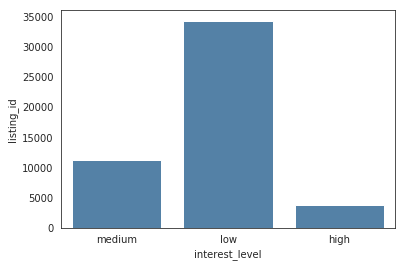

In [9]:
sns.barplot(x='interest_level', y='listing_id', data=train_df.reset_index(),
            label='Training', estimator=np.ma.count, color='steelblue')

There seems to be way more low interest listings than high interest listings. Normally, the classes with fewer samples would have higher impacts on the evaluation so we may want to pay more attention on high interest listings when modeling the problem.

Another interesting thing is that though this is supposed to be a classification problem (assuming interest level is nominal), however it's not hard to imagine that it can also be considered as a regression problem (assuming interest level is ordinal). That said, if we convert interest level from categorical to numeric and given them arbitrarily meaningful values hopefully we can get some useful insights as the numeric values are relatively easy to analyze.

In [10]:
train_df['interest_level'] = train_df['interest_level'].apply(lambda x: 0 if x=='low' else 1 if x=='medium' else 2)

## Numeric features

We will be using two plots for analyzing numeric features:

* s.distplot()
* s.boxplot()

### Price

We will get started with analyzing price, an important feature that We don't have to have expert knowledge in the property renting business to be aware of its importance.

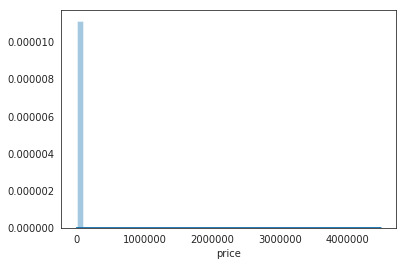

In [11]:
sns.distplot(train_df.price)

There seems to be outliers on price which are unreasonably high. The distribution plot also becomes hard to read because of the outliers. One way to mitigate this problem is to impute the outliers with the upper or lower limit:

In [12]:
import copy
vis_train_df = copy.copy(train_df)

for col in num_cols:
    upper_limit = np.percentile(train_df[col], 99)
    lower_limit = np.percentile(train_df[col], 1)
    vis_train_df.loc[vis_train_df[col]>upper_limit, col] = upper_limit
    vis_train_df.loc[vis_train_df[col]<lower_limit, col] = lower_limit



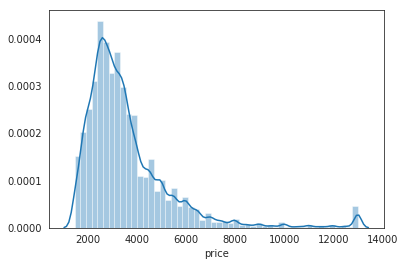

In [13]:
sns.distplot(vis_train_df.price)

Now it looks much better and we can easily tell that the data is somehow bell-shaped with a skewness to the right. We can also use boxplot to show the median, quartiles and outliers

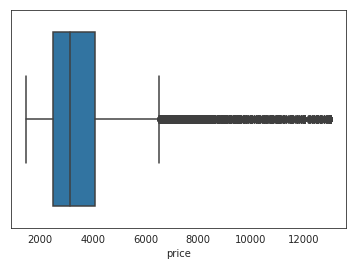

In [14]:
sns.boxplot(vis_train_df.price)

violinplot() is a variant of boxplot(). It provides a better view of data distribution but in the meantime lose the explicit quartiles and median marks.

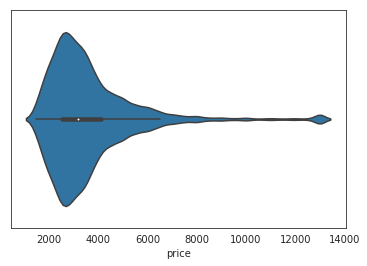

In [15]:
sns.violinplot(vis_train_df.price)

We can also create box plots by interest level. Not surprisingly It appears that low interest listings have a higher median price and high interest listings have a lower median price.

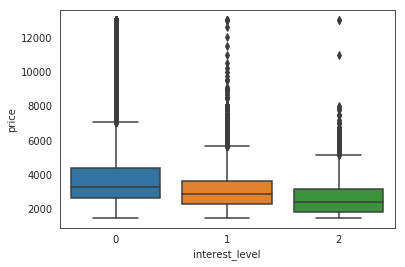

In [16]:
sns.boxplot(x='interest_level', y='price', data=vis_train_df)

### Bedrooms

We are going to use barplot() instead of distplot() for bedrooms and bathrooms as they are discrete as opposed to continuous. 

Text(0, 0.5, 'Number of Occurrences')

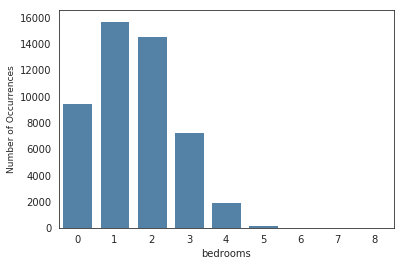

In [17]:
sns.barplot(x='bedrooms', y='listing_id', data=train_df.reset_index(),
            label='Training', estimator=np.ma.count, color='steelblue')
plt.ylabel('Number of Occurrences', fontsize=9)

### Bathrooms

Text(0, 0.5, 'Number of Occurrences')

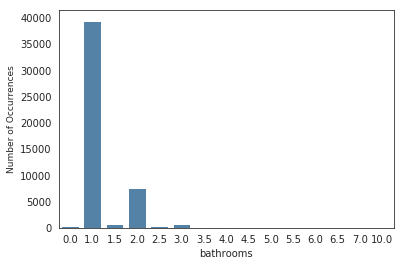

In [18]:
sns.barplot(x='bathrooms', y='listing_id', data=train_df.reset_index(),
            label='Training', estimator=np.ma.count, color='steelblue')
plt.ylabel('Number of Occurrences', fontsize=9)

### Plot relationship between features

Sometimes we would like to see the relationship between features such as bedrooms vs. bathrooms. A scatter plot would be useful for this:

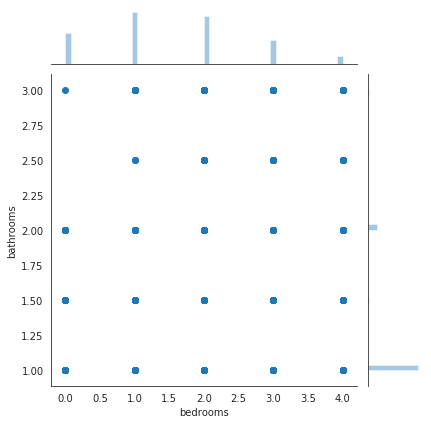

In [19]:
sns.jointplot(x='bedrooms', y='bathrooms', data=vis_train_df)

However, because of the discreteness of the two features we are not able to get more insights. In the meantime, it might be interesting to color the samples by interest level and add simple regression lines that each represents a fitted regression on bathrooms = f(bedrooms) for corresponding interest level:

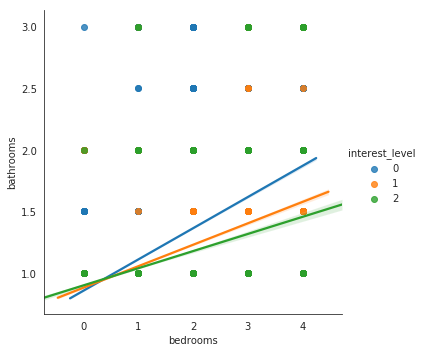

In [20]:
sns.lmplot(x='bedrooms', y='bathrooms', data=vis_train_df, hue='interest_level')

Interestingly, high interest listings have a smaller slope than those who are of low interest. In another word, for the same number of bedrooms, the more bathrooms the less interest it is.

### Latitude and longitude

Geolocation is another important aspect for this problem. We will start from analyzing latitude and longitude individually the n put them together

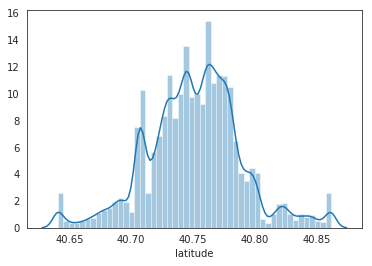

In [21]:
sns.distplot(vis_train_df.latitude)

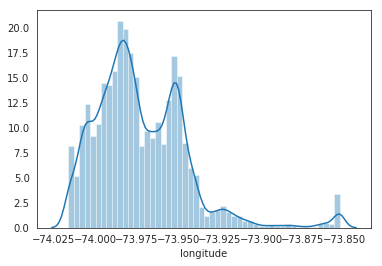

In [22]:
sns.distplot(vis_train_df.longitude)

In [23]:
from bokeh.io import output_notebook, show, curdoc
from bokeh.models import ColumnDataSource, GMapOptions, Circle, CustomJS
from bokeh.plotting import gmap
from bokeh.layouts import widgetbox, row, column
from bokeh.models.widgets import CheckboxGroup

output_notebook()

pal = sns.color_palette().as_hex()

GOOGLE_API_KEY = "YOURGOOGLEAPIKEY"


Loading BokehJS ...

In [24]:
map_options = GMapOptions(lat=40.75111543438969, lng=-73.9725776826471, map_type="roadmap", zoom=11)

p = gmap(GOOGLE_API_KEY, map_options, title="Renthop Listings")

vis_train_geo_df = train_df[['longitude', 'latitude', 'interest_level']]
vis_train_geo_df['color'] = vis_train_geo_df['interest_level'].apply(lambda x:pal[x]).values

source= ColumnDataSource(data=vis_train_geo_df)

p.circle(x="longitude", y="latitude", size=8, fill_color='color', fill_alpha=1, source=source)
show(p)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


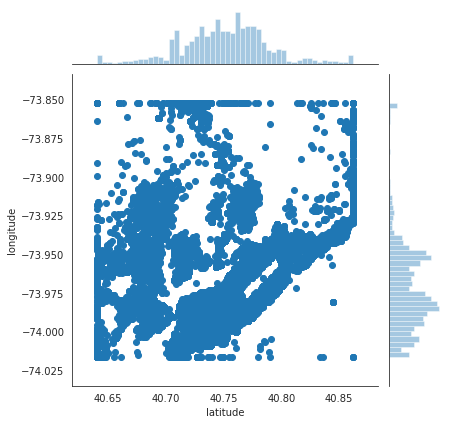

In [25]:
sns.jointplot(x='latitude', y='longitude', data=vis_train_df)

It might useful to use a kde plot (kernel density estimation) instead of the scatter plot to show the density of the listings. There are apparently some hot spots. In addition to using lat/lon directly we may also want to rasterize (create grids based on lat/lon) the data for feature engineerings. 

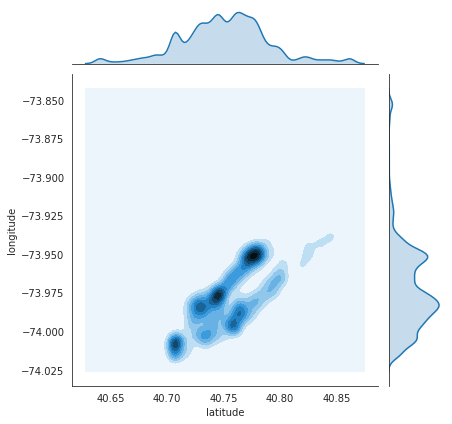

In [26]:
sns.jointplot(x='latitude', y='longitude', data=vis_train_df, kind='kde')

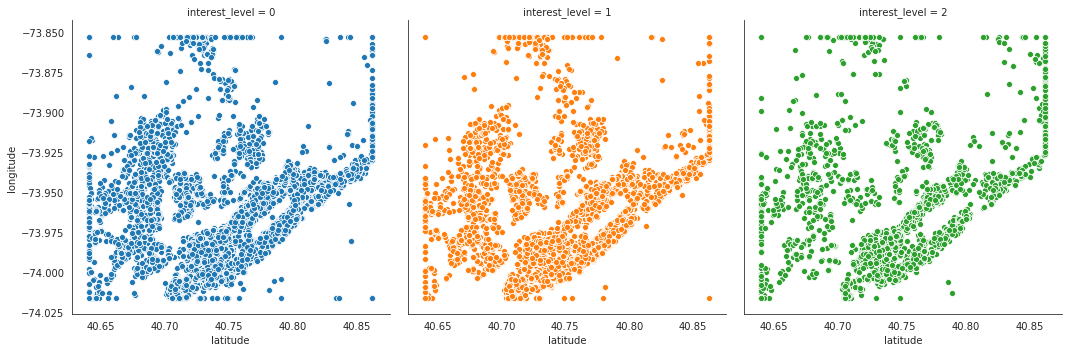

In [27]:
g = sns.FacetGrid(vis_train_df, hue="interest_level", col="interest_level", height=5)
g.map(sns.scatterplot, 'latitude', 'longitude')

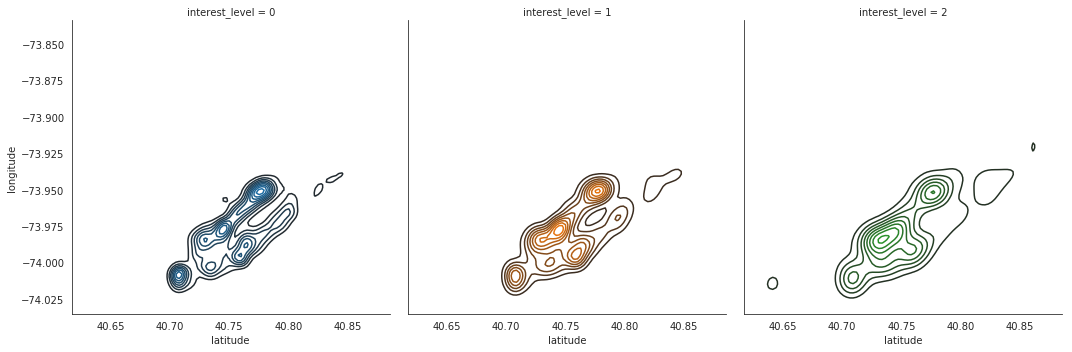

In [28]:
g = sns.FacetGrid(vis_train_df, hue="interest_level", col="interest_level", height=5)
g.map(sns.kdeplot, 'latitude', 'longitude')

## Date-time features

In [29]:
vis_train_df['created_date'] = vis_train_df['created'].dt.date
vis_train_df['created_month'] = vis_train_df['created'].dt.month
vis_train_df['created_day'] = vis_train_df['created'].dt.day
vis_train_df['created_hour'] = vis_train_df['created'].dt.hour
vis_train_df['created_weekday'] = vis_train_df['created'].dt.weekday

dt_num_vars = ['created_date', 'created_month', 'created_hour', 'created_weekday']

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


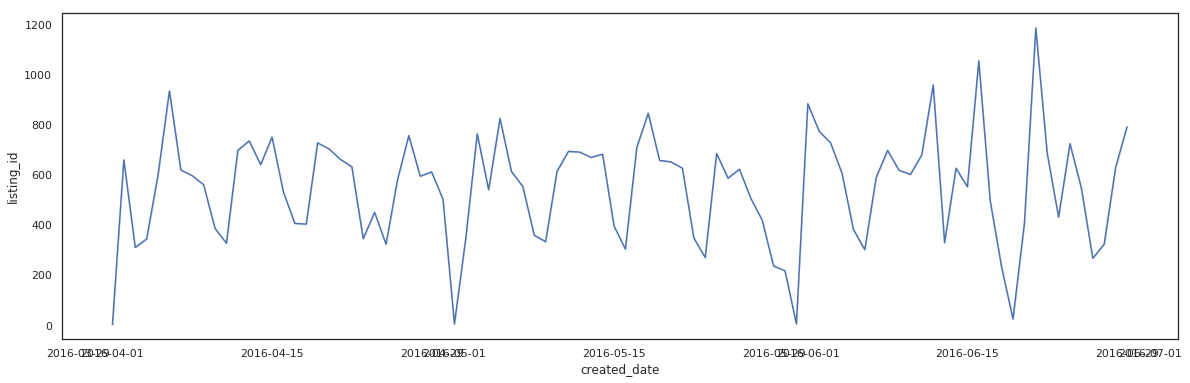

In [30]:
sns.set(rc={'figure.figsize':(20,6)})
sns.set_style("white")
sns.lineplot(x="created_date", y="listing_id",
             data=vis_train_df.reset_index(), estimator=np.ma.count)

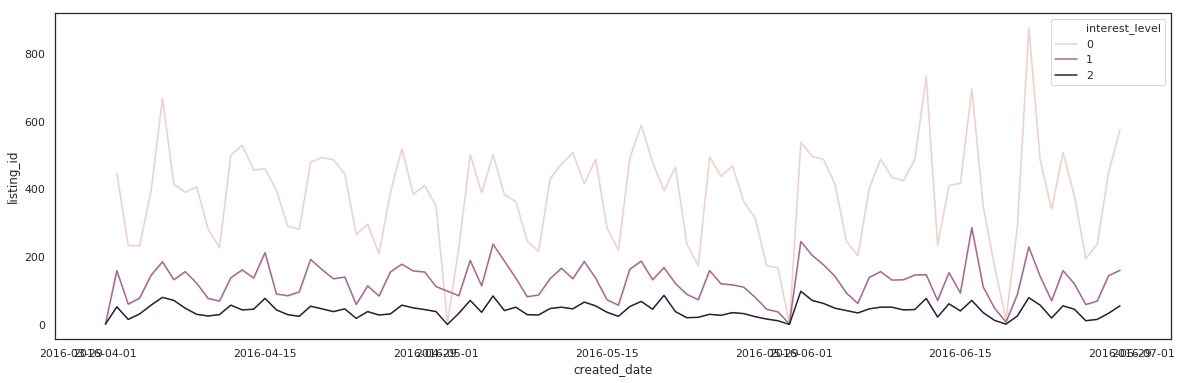

In [31]:
sns.set(rc={'figure.figsize':(20,6)})
sns.set_style("white")
sns.lineplot(x="created_date", y="listing_id",
             data=vis_train_df.reset_index(), estimator=np.ma.count, hue='interest_level')

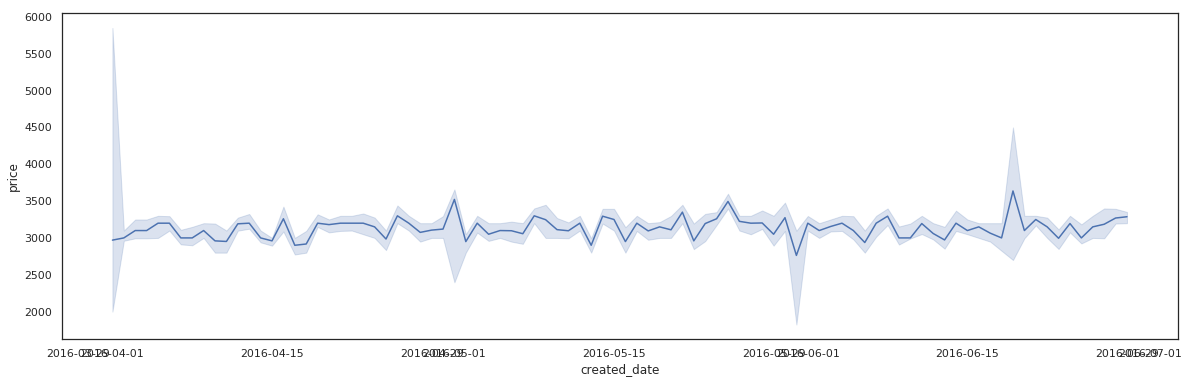

In [32]:
sns.set(rc={'figure.figsize':(20,6)})
sns.set_style("white")
sns.lineplot(x="created_date", y="price",
             data=vis_train_df, estimator=np.median)

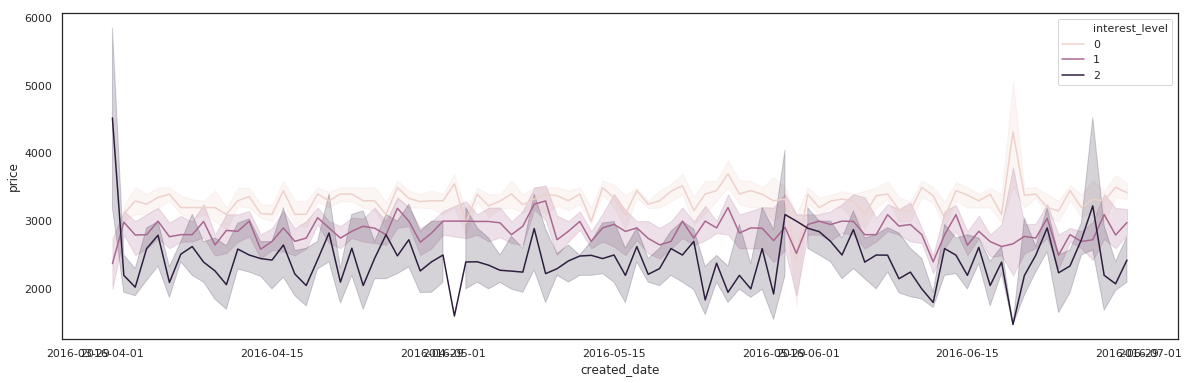

In [33]:
sns.set(rc={'figure.figsize':(20,6)})
sns.set_style("white")
sns.lineplot(x="created_date", y="price",
             data=vis_train_df, estimator=np.median, hue='interest_level')

Text(0, 0.5, 'Number of Occurrences')

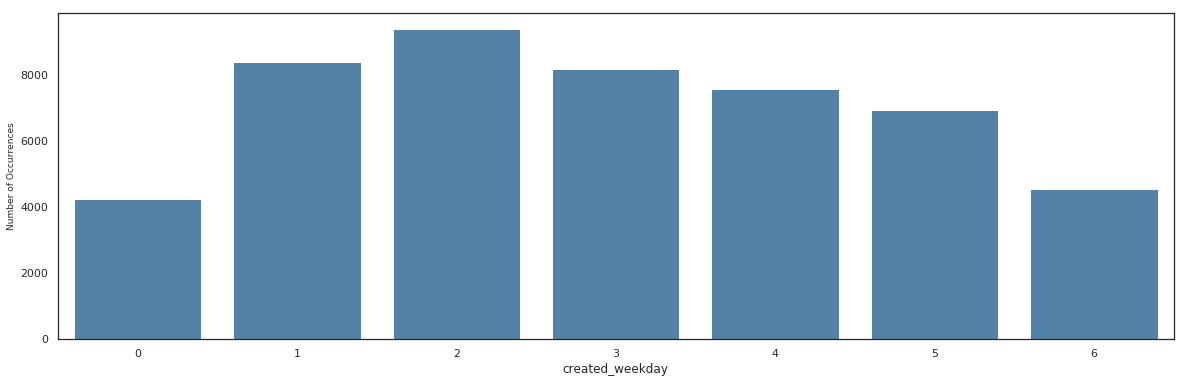

In [34]:
sns.barplot(x='created_weekday', y='listing_id', data=vis_train_df.reset_index(),
            label='Training', estimator=np.ma.count, color='steelblue')
plt.ylabel('Number of Occurrences', fontsize=9)

Text(0, 0.5, 'Number of Occurrences')

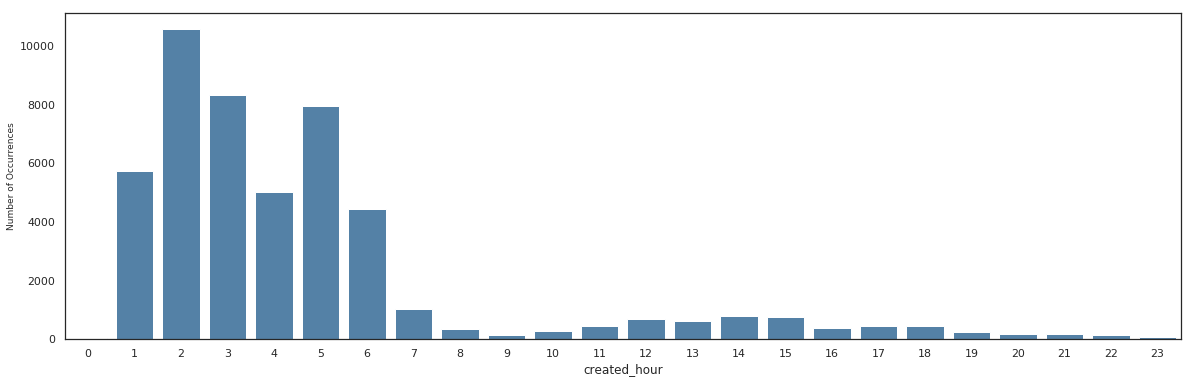

In [35]:
sns.barplot(x='created_hour', y='listing_id', data=vis_train_df.reset_index(),
            label='Training', estimator=np.ma.count, color='steelblue')
plt.ylabel('Number of Occurrences', fontsize=9)

## Categorical features

For categorical features the first thing we would like to know is the cardinality, i.e. how many unique values are there for each feature. Depending on the degree of cardinality we may want to use different encoding strategy:

In [36]:
vis_train_df[['manager_id', 'building_id']].describe()

manager_id building_id
count                              49352       49352
unique                              3481        7585
top     e6472c7237327dd3903b3d6f6a94515a           0
freq                                2533        8286

### manager_id

Given that the cardinality of manager_id is very high (3485 unique values) we will only visualize the top 50 manager_id on bar chart:

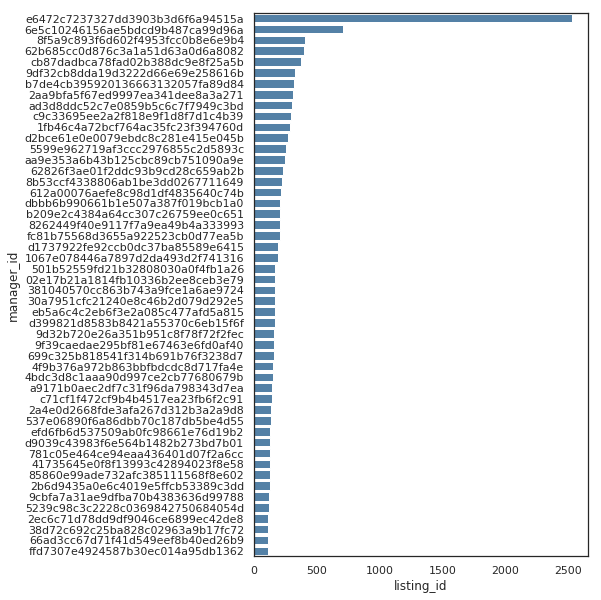

In [37]:
sns.set(rc={'figure.figsize':(6,10)})
sns.set_style("white")
sns.barplot(y='manager_id', x='listing_id', 
            data=vis_train_df.reset_index().groupby('manager_id').listing_id.count().sort_values(ascending=False).head(50).reset_index(),
            color='steelblue'
           )

Next, let's take a look at the distribution of count of listings by manager id. Given the long tail we will only visualize those managers with listings greater less than 100

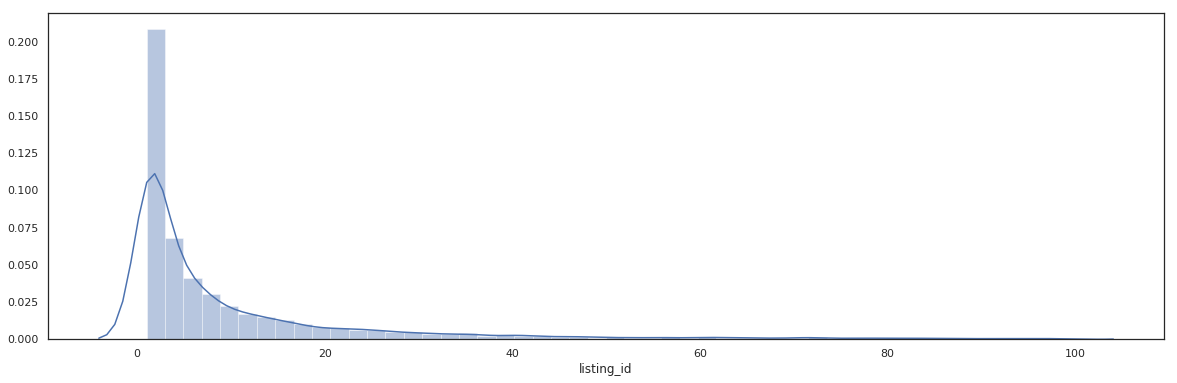

In [38]:
sns.set(rc={'figure.figsize':(20,6)})
sns.set_style("white")
sns.distplot(vis_train_df.reset_index().groupby('manager_id').listing_id.count().loc[lambda x:x<100])

It would be interesting to compare the count of the listings vs. the mean of interest level:

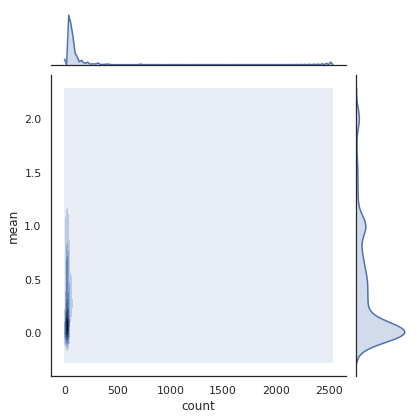

In [39]:
sns.jointplot(x='count',y='mean', 
             data=vis_train_df.groupby('manager_id').interest_level.agg(['count', 'mean']).reset_index(),
          kind='kde',
            )

Let's zoom a bit then something really interesting emerges:

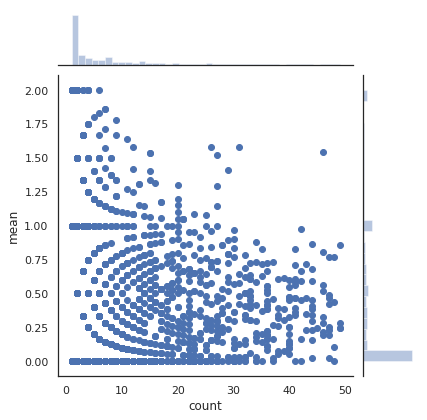

In [40]:
sns.jointplot(x='count', y='mean',
              data=vis_train_df.groupby('manager_id').interest_level.agg(
                  ['count', 'mean']).reset_index().query('count<50'),
#               kind='kde',
              )

Instead of comparing mean and count, let's compare count and std:

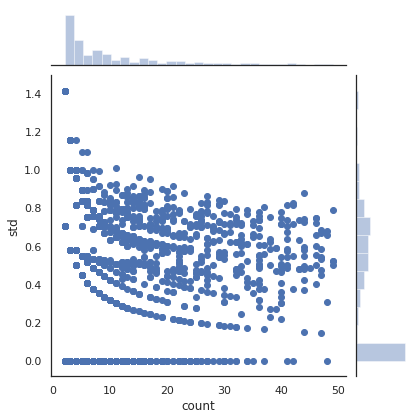

In [41]:
sns.jointplot(x='count', y='std',
              data=vis_train_df.groupby('manager_id').interest_level.agg(
                  ['count', 'std']).reset_index().query('count<50'),
#               kind='kde',
              )

The takeaway is that as the more listings a manager has, the less variant the interest level is. What does it actually mean is that manager id could be an very important feature particularly for those managers who manage large number of listings! 

### building_id

We can do the same thing for building id:

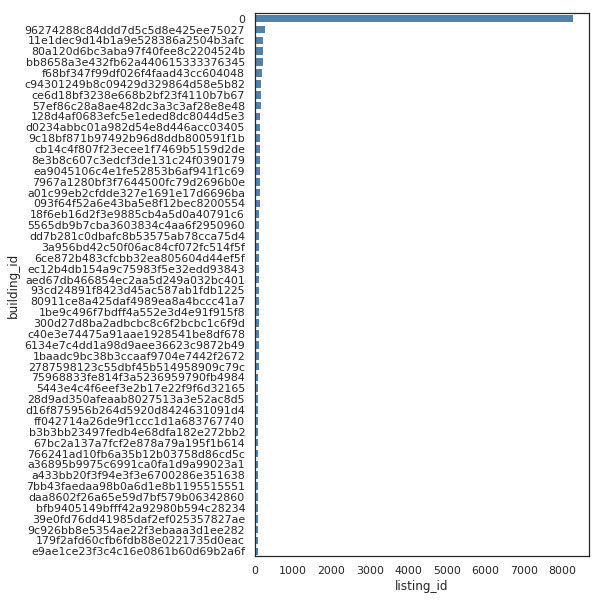

In [42]:
sns.set(rc={'figure.figsize':(6,10)})
sns.set_style("white")
sns.barplot(y='building_id', x='listing_id', 
            data=vis_train_df.reset_index().groupby('building_id').listing_id.count().sort_values(ascending=False).head(50).reset_index(),
            color='steelblue'
           )

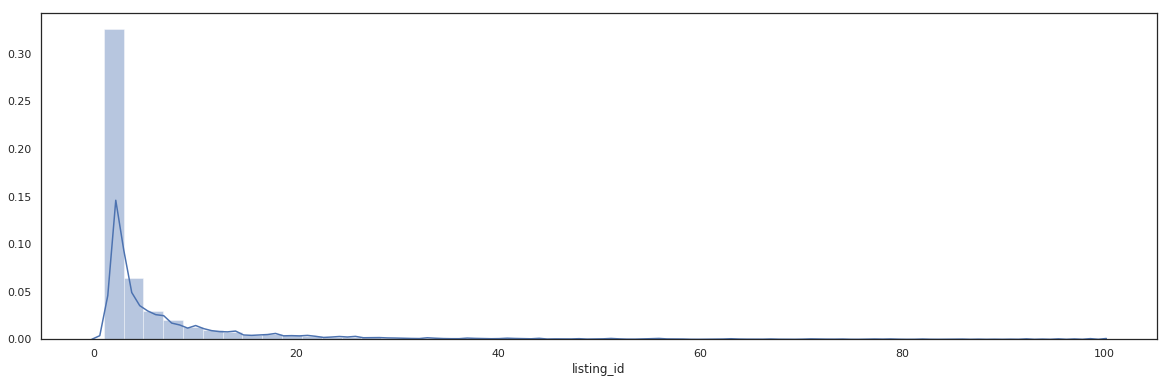

In [43]:
sns.set(rc={'figure.figsize':(20,6)})
sns.set_style("white")
sns.distplot(vis_train_df.reset_index().groupby('building_id').listing_id.count().loc[lambda x:x<100])

Noticeably that there are more than 8000 listings with building_id 0, which doesn't seem to be a placeholder than an actual value. We may want to try other imputation methods instead of using 0 directly when engineering features.

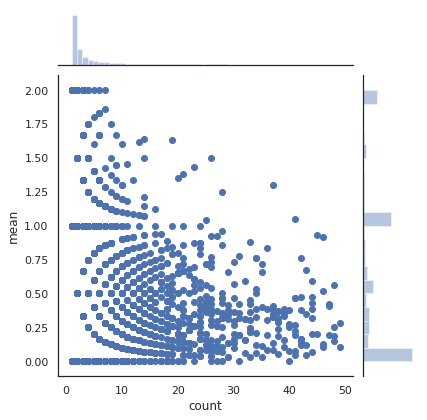

In [44]:
sns.jointplot(x='count', y='mean',
              data=vis_train_df.groupby('building_id').interest_level.agg(
                  ['count', 'mean']).reset_index().query('count<50'),
              )

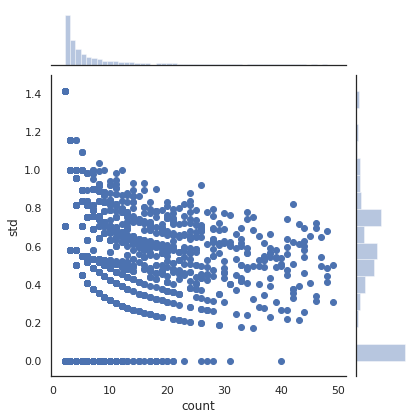

In [45]:
sns.jointplot(x='count', y='std',
              data=vis_train_df.groupby('building_id').interest_level.agg(
                  ['count', 'std']).reset_index().query('count<50'),
              )

We found similar patterns on building_id as manager_id, which is an indicator that building_id could be another useful source for feature engineering.

## Text features

### display_address

In [46]:
#Preprocessing
from wordcloud import WordCloud
from wordcloud import STOPWORDS

STOPWORDS.add('kaggle')
STOPWORDS.add('kagglemanager')
STOPWORDS.add('kagglemanager@renthop.com')
STOPWORDS.add('renthop.com')
STOPWORDS.add('br')

CPU times: user 2.26 s, sys: 84.1 ms, total: 2.35 s
Wall time: 2.35 s


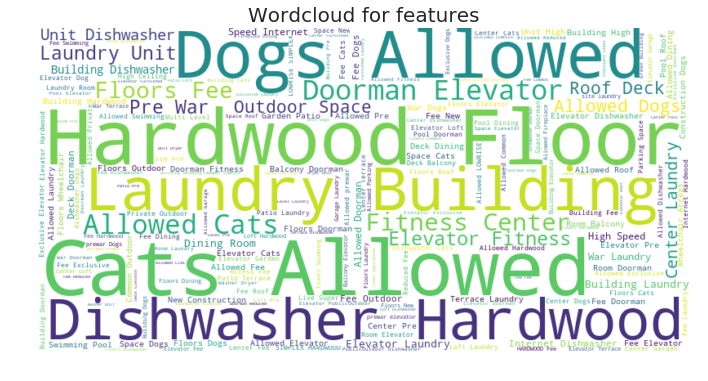

In [47]:
%%time
wordcloud = WordCloud(background_color='white', width=800, height=400, max_font_size=100, max_words=200, stopwords=STOPWORDS)\
    .generate(' '.join(vis_train_df['features'].apply(lambda x: ' '.join(x)).values))
plt.title("Wordcloud for features", fontsize=20)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

CPU times: user 1.15 s, sys: 22 ms, total: 1.18 s
Wall time: 1.17 s


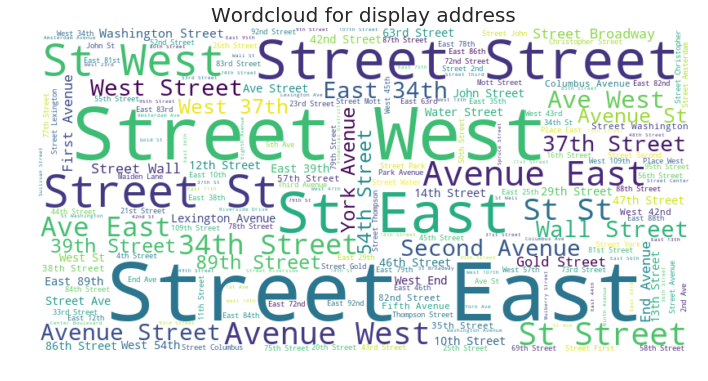

In [48]:
%%time
wordcloud = WordCloud(background_color='white', width=800, height=400, max_font_size=100, max_words=200, stopwords=STOPWORDS)\
    .generate(','.join(vis_train_df['display_address'].values))
plt.title("Wordcloud for display address", fontsize=20)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

CPU times: user 1.16 s, sys: 23 ms, total: 1.19 s
Wall time: 1.18 s


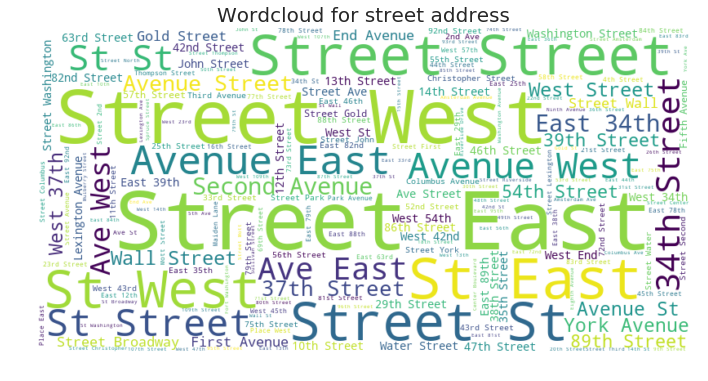

In [49]:
%%time
wordcloud = WordCloud(background_color='white', width=800, height=400, max_font_size=100, max_words=200, stopwords=STOPWORDS)\
    .generate(','.join(vis_train_df['street_address'].values))
plt.title("Wordcloud for street address", fontsize=20)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

CPU times: user 18.2 s, sys: 664 ms, total: 18.8 s
Wall time: 18.8 s


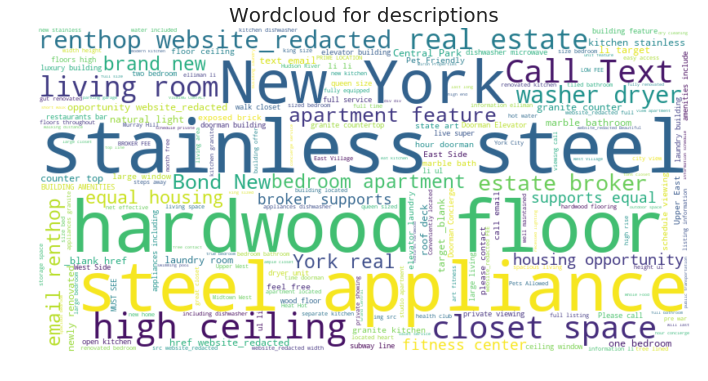

In [50]:
%%time
plt.figure(figsize=(20,6))
wordcloud = WordCloud(background_color='white', width=800, height=400, max_font_size=100, max_words=200, stopwords=STOPWORDS)\
.generate(','.join(vis_train_df['description'].values))
plt.title("Wordcloud for descriptions", fontsize=20)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

## Pair plot

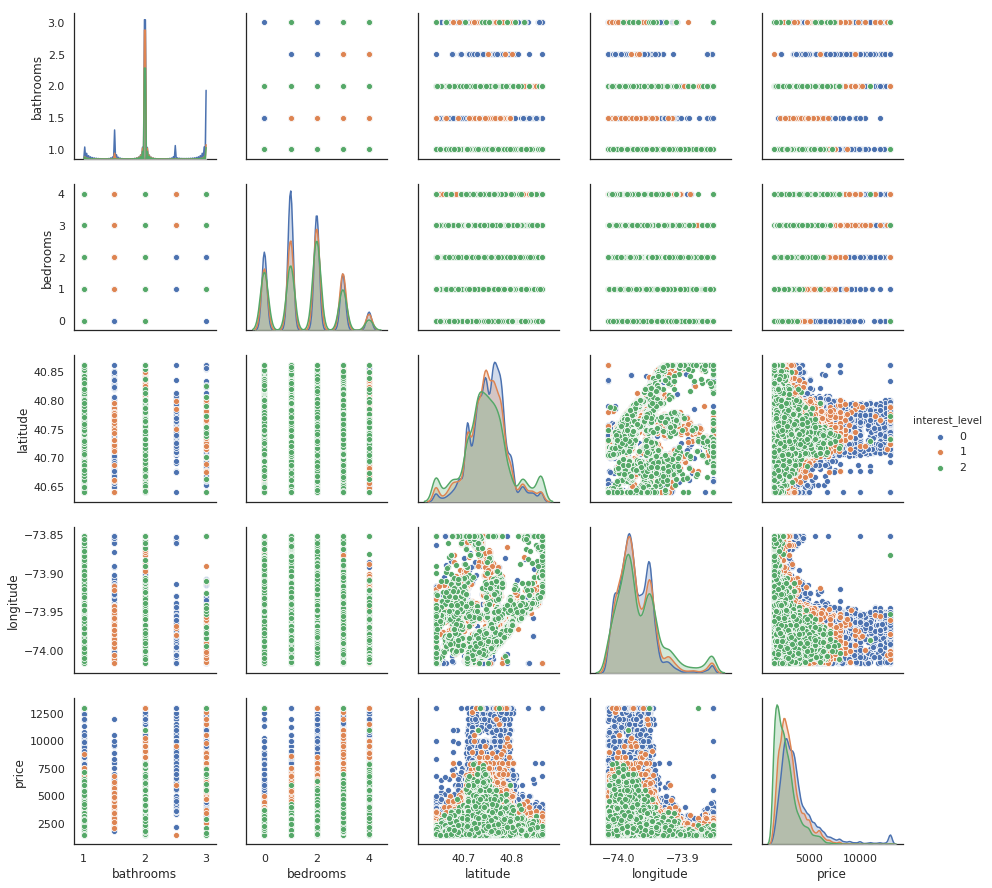

In [51]:
sns.pairplot(vis_train_df, vars=num_cols, hue='interest_level')

## Feature correlation

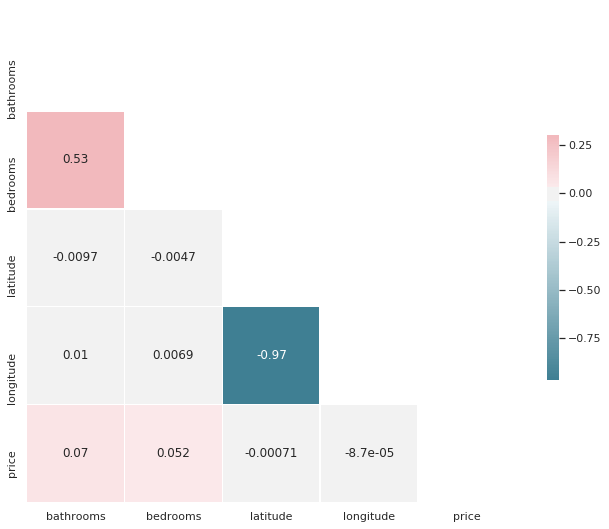

In [52]:
corr = train_df[num_cols].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})